In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pathlib

Langevin equation:

$$ m \ddot{x}\left(t\right) = - \int_0^t \frac{2 m \gamma}{\pi} \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} \dot{x}\left(\tau\right) d \tau + \xi\left(t\right) $$

Where

$$ \left\langle \xi\left(t\right) \xi\left(t+\tau\right) \right\rangle = \frac{2 \gamma m}{ \pi} \frac{\epsilon^2 - \tau^2}{\left(\epsilon^2+\tau^2\right)^2}$$

Let us generate the noise sample $ \xi\left(t\right) $:

In [2]:
# generate random noise sample
w_max = 200
w = np.linspace(0, w_max, num=120000)
n_w = len(w)
dw = w[1] - w[0]
epsilon = 0.1
sqrt_J = np.zeros(n_w, dtype=complex)

for i in range(n_w):
    sqrt_J[i] = math.sqrt(dw / 2) * math.sqrt(w[i] * math.exp(-epsilon * w[i]))

t_max = 30
t = np.linspace(0, t_max, num=3000)
dt = t[1] - t[0]
n_t = len(t)


Define memory function:

$$ M\left(t\right) =  \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} $$

In [3]:
M = np.zeros(n_t) 

for i in range(n_t):
    M[i] = epsilon / (epsilon**2 + (t[i] - t[0])**2) * dt
    
# trapezoidal rule
M[0] = M[0] / 2

(0.0, 1.0)

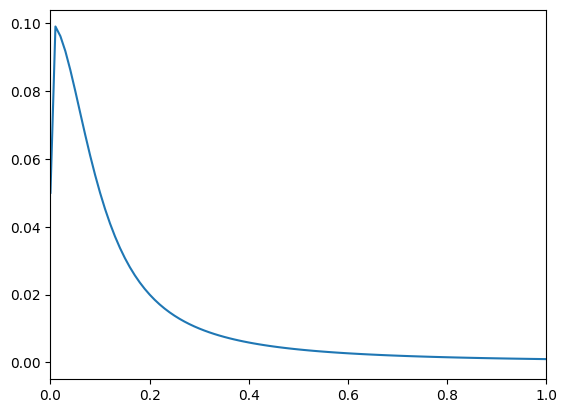

In [4]:
# how the memory M(t) looks like
plt.plot(t, M)
plt.xlim(0, 1)

Let us solve the Langevin equation:

In [5]:
def ode_midpoint(dt, RHS, initial_state, start_time = None, start_index = None, end_time = None, end_index = None, tol = 10**(-6)):

    K = initial_state.size

    use_time = False
    use_index = False

    if not start_time is None and not end_time is None:

        use_time = True
        nt = math.floor((end_time - start_time) / dt)

    if not start_index is None and not end_index is None:

        use_index = True
        nt = end_index - start_index

    if not use_index != use_time:
        raise ValueError('evolution should be called either in time or in step-index mode')


    if (use_index):
        yield (start_index, initial_state)
    else:
        yield (start_time, initial_state)

    psi = np.copy(initial_state)
    psi_mid = np.copy(psi)

    b = nt - 1

    for i in range(0, b):

        psi_mid[:] = psi

        if (use_index):
            
            time_moment = start_index + i
            
        else:
            
            time_moment = start_time + (i + 0.5) * dt
            
        while(True):

            psi_mid_next = RHS(time_moment, psi_mid)

            psi_mid_next = psi + dt / 2 * psi_mid_next

            err = max(abs(psi_mid_next - psi_mid))

            swp = psi_mid_next
            psi_mid_next = psi_mid
            psi_mid = swp

            if err < tol:
                break

        psi = 2 * psi_mid - psi

        if (use_index):
            yield (start_index + i + 1, psi)
        else:
            yield (start_time + i * dt, psi)

Langevin equation in terms of momentum:

$$ m \dot{p}\left(t\right) = - \int_0^t \frac{2 m \gamma}{\pi} \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} p\left(\tau\right) d \tau + \xi\left(t\right) $$

In [7]:
def compute_trajectory(job_id):
    
    # generate initial noise sample
    z = np.random.normal(size=n_w) + 1j * np.random.normal(size=n_w)
    z = z / math.sqrt(2)
    xi = np.zeros(n_t, dtype=complex)
    for j in range(n_t):
        e = np.exp(-1j * w * t[j])
        xi_pos = z * sqrt_J * e
        xi_neg = xi_pos.conjugate()
        xi[j] = np.sum(xi_pos) + np.sum(xi_neg[1:]) 

    # solve for momentum trajectory
    p0 = np.array([0])
    p_trajectory = []
    def RHS(ti, p_mid):
        n_memory = len(p_trajectory)
        rhs = -sum(M[:n_memory+1] * ([p_mid[0]] + p_trajectory[::-1])) + (xi[ti] + xi[ti + 1]) / 2
        return rhs
    for ti, p in ode_midpoint(dt, RHS, p0, start_index = 0, end_index = n_t - 1):
        p_trajectory.append(p[0])
        
    # integrate
    x_trajectory = [0]
    for i in range(1, len(p_trajectory)):
        x = x_trajectory[i - 1] + p_trajectory[i] * dt
        x_trajectory.append(x)
        
    # save trajectory
    path = os.path.join(os.getcwd(), "results_2", "x_" + str(job_id) + ".txt")
    os.makedirs(os.path.dirname(path), exist_ok = True)
    with open(path, "w") as f:
        for i in range(len(x_trajectory)):
            print(str(i * dt) + " " + str(x_trajectory[i].real), file = f)

In [ ]:
from joblib import Parallel, delayed

# number of trajectories
m = 10000

_ = Parallel(n_jobs=-1)(
    delayed(compute_trajectory)(i) for i in range(m)
)

In [53]:
# read results
x = []
folder = "results"
for i in range(m):
    p = os.path.join(os.getcwd(), folder, "x_" + str(i) + ".txt")
    p = pathlib.Path(p)
    if not p.exists():
        continue
    with p.open() as f:
        data = np.loadtxt(f)    
        x.append(data[:, 1])

In [54]:
def compute_x2(x, ti_skip):
    # Compute dispersion along trajectory
    n_t_ = len(x[0])

    x2 = np.zeros(n_t_ - ti_skip)

    for x_trajectory in x:
        for i in range(ti_skip, n_t_):
            x2[i - ti_skip] += (x_trajectory[i] - x_trajectory[ti_skip])**2

    x2 = x2 / len(x)    
    
    return x2

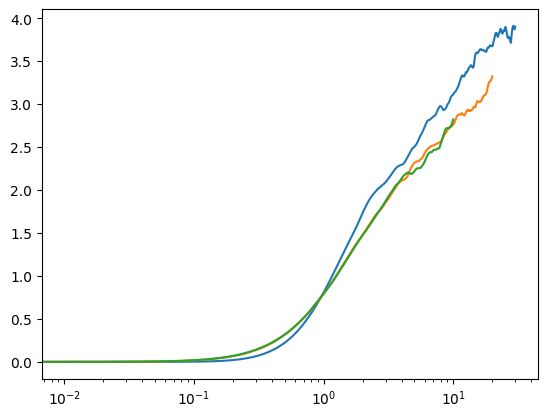

In [56]:
x2 = compute_x2(x, 0)
plt.plot(t[:len(x2)], x2)
x2 = compute_x2(x, 1000)
plt.plot(t[:len(x2)], x2)
x2 = compute_x2(x, 2000)
plt.plot(t[:len(x2)], x2)
plt.xscale('log')

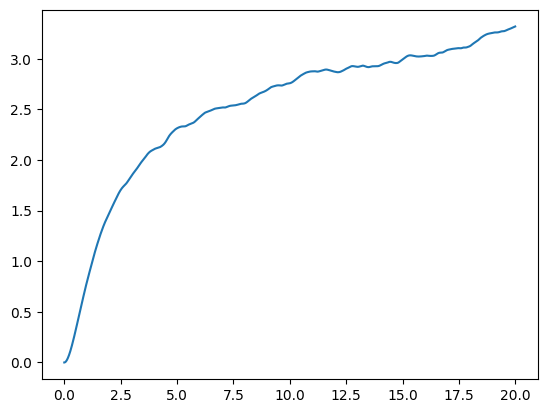

In [57]:
x2 = compute_x2(x, 1000)
plt.plot(t[:len(x2)], x2)

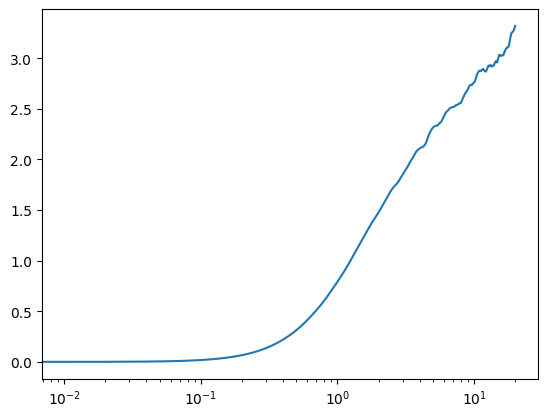

In [58]:
x2 = compute_x2(x, 1000)
plt.plot(t[:len(x2)], x2)
plt.xscale('log')